In [5]:
%matplotlib nbagg

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from skimage import io, img_as_float64
from tqdm import tqdm
import elasticdeform
from tifffile import imwrite

In [6]:
import ipdb

In [7]:
# Retrieve train images
images = io.imread('data/train-volume.tif') / 255
labels = io.imread('data/train-labels.tif') / 255
print(images.shape)
print(labels.shape)

(30, 512, 512)
(30, 512, 512)


<IPython.core.display.Javascript object>


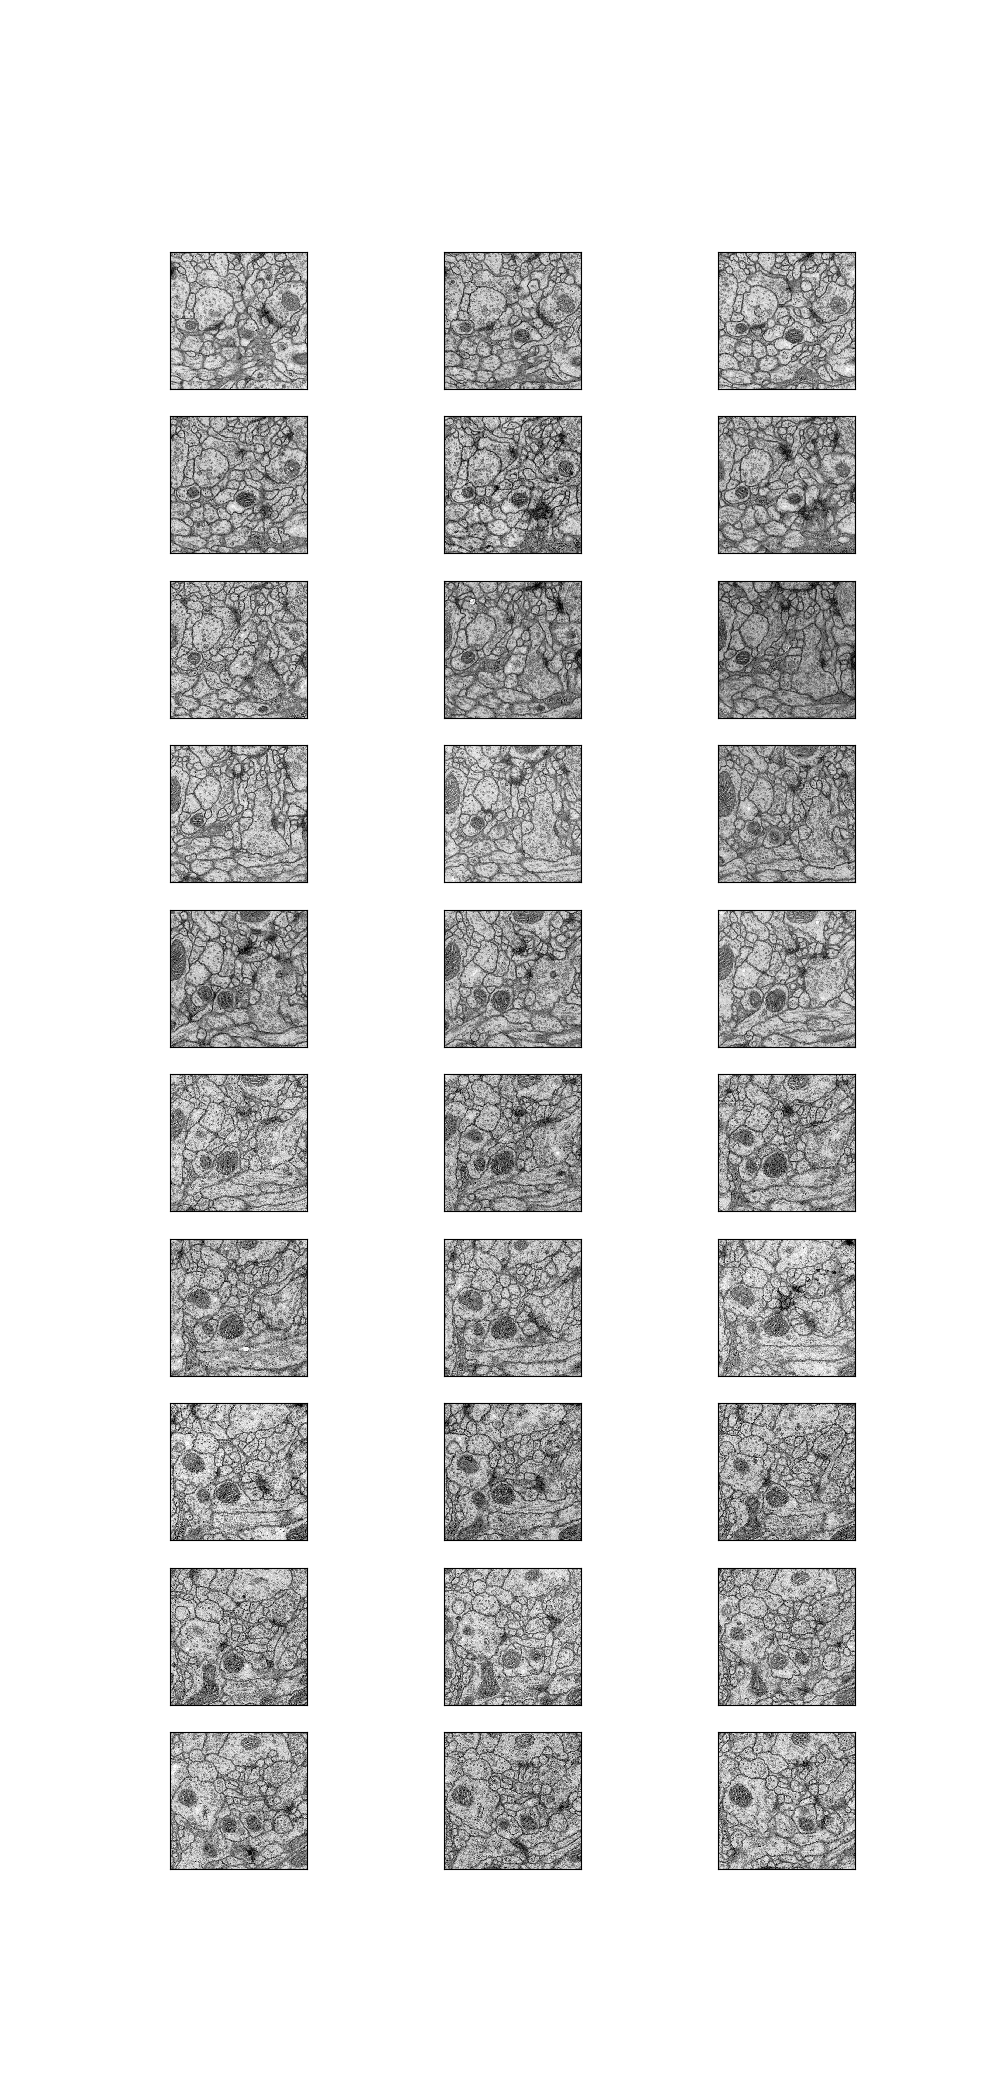

In [3]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

<IPython.core.display.Javascript object>


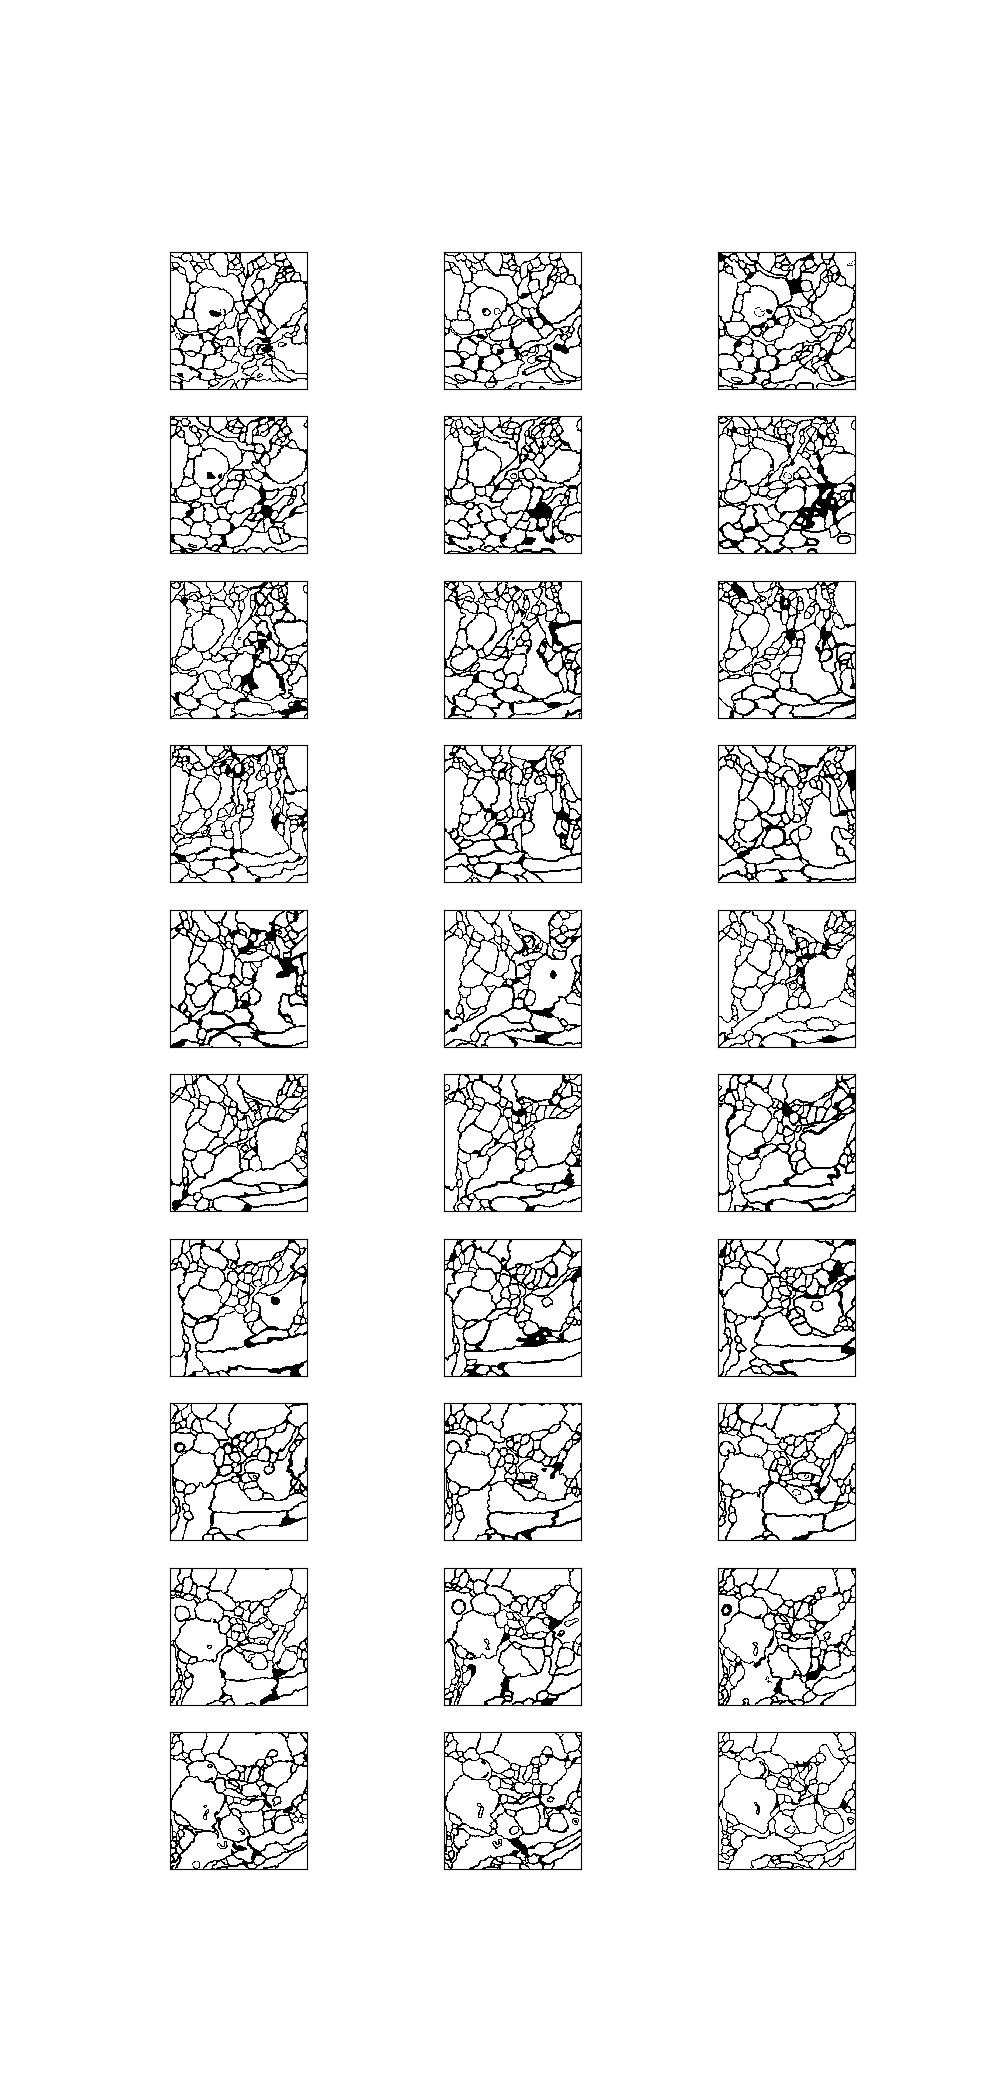

In [4]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), labels):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

<IPython.core.display.Javascript object>


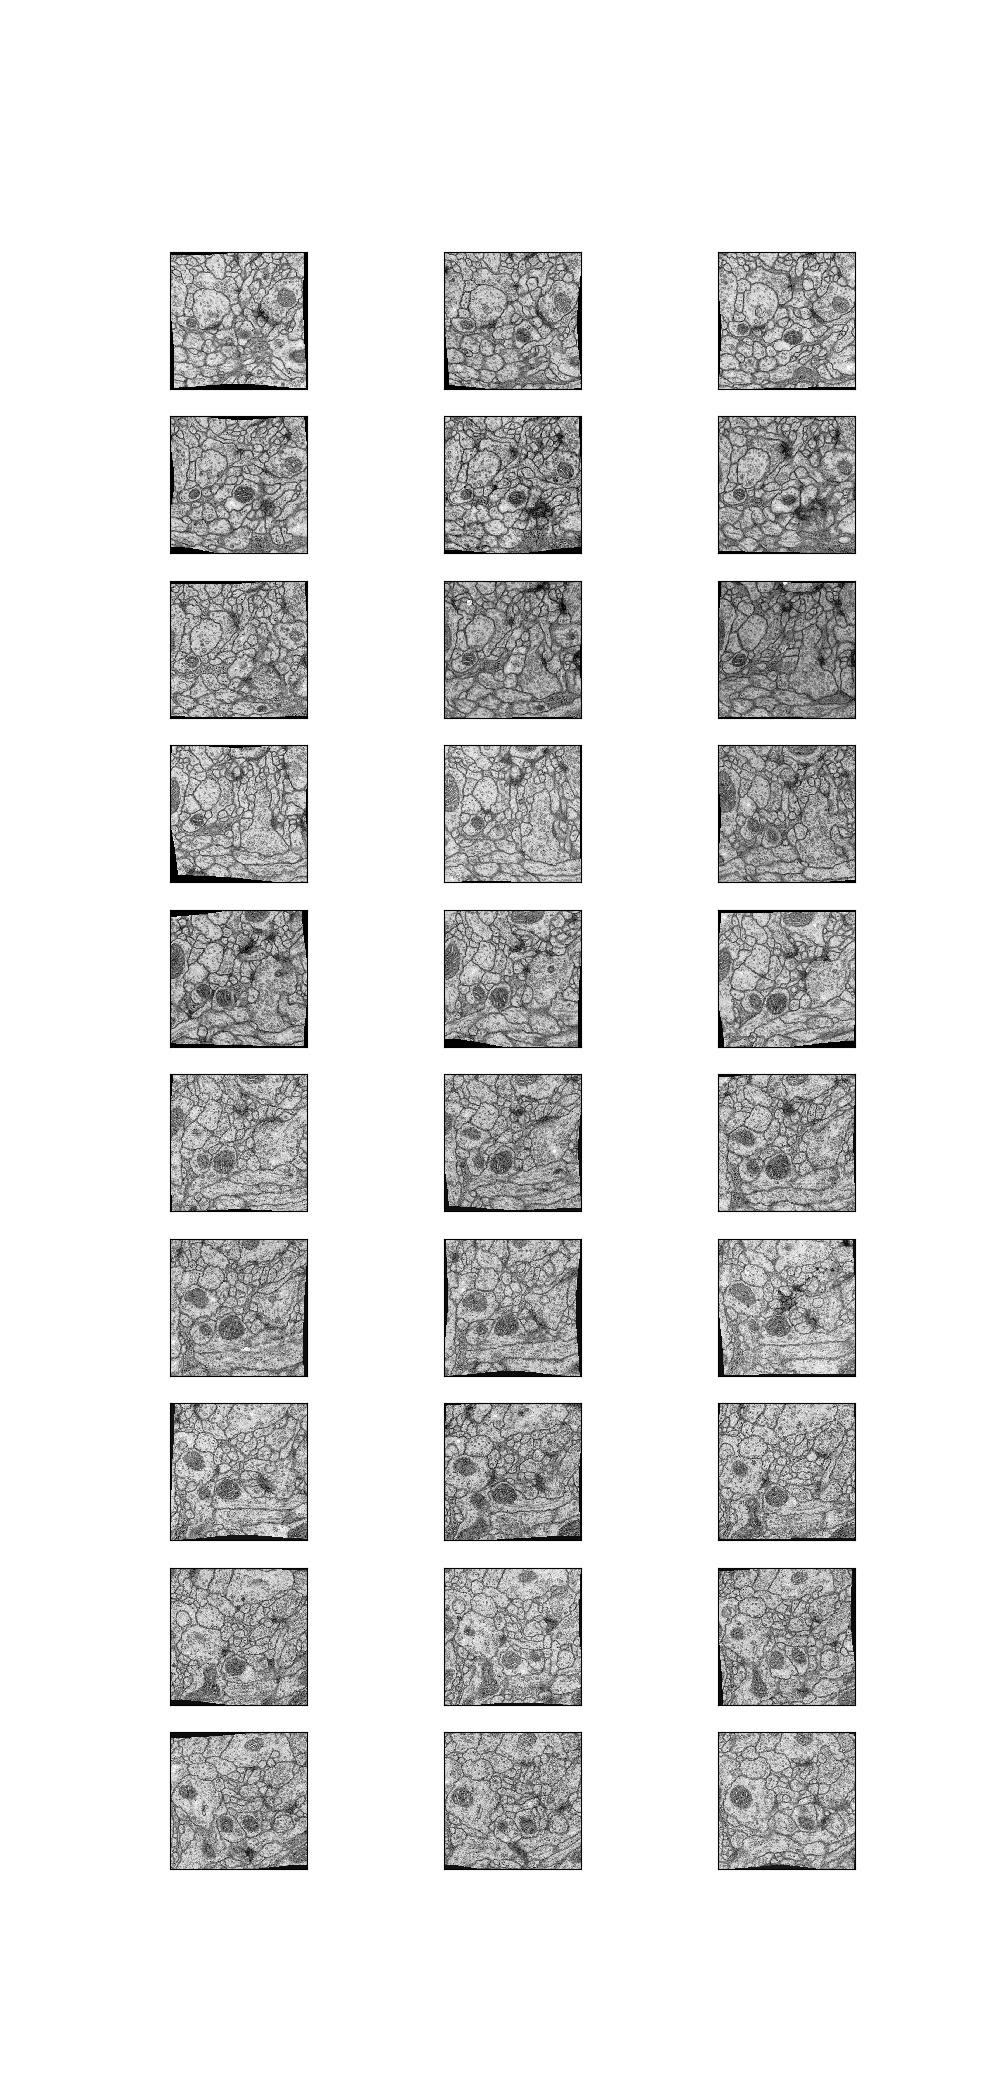

In [5]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img = elasticdeform.deform_random_grid(img, sigma=10, points=3)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

In [6]:
print(np.unique(labels))
print(np.mean(labels))

[0. 1.]
0.7803688049316406


In [114]:
X = images[4]

In [112]:
X_ = np.zeros((X.shape[0] + 2*199, X.shape[1] + 2*199))
X_[199: X.shape[0] + 199, 199: X.shape[1] + 199] = X
# Complete X_ at left and right
X_[199:199+X.shape[0], 0:199] = np.fliplr(X[:,:199])
X_[199:199+X.shape[0], 199+X.shape[0]:] = np.fliplr(X[:, -199:])
# Complete X_ at up and down
X_[:199, 199: 199+X.shape[1]:] = np.flipud(X[:199,:])
X_[-199:, 199: 199+X.shape[1]:] = np.flipud(X[-199:,:])
# Complete corners
X_[:199, :199] = np.flip(X[:199, :199]) # left-up
X_[-199:, :199] = np.flip(X[-199:, :199]) # left-down
X_[:199, -199:] = np.flip(X[:199, -199:]) # right-up
X_[-199:, -199:] = np.flip(X[-199:, -199:]) # right-down

<IPython.core.display.Javascript object>


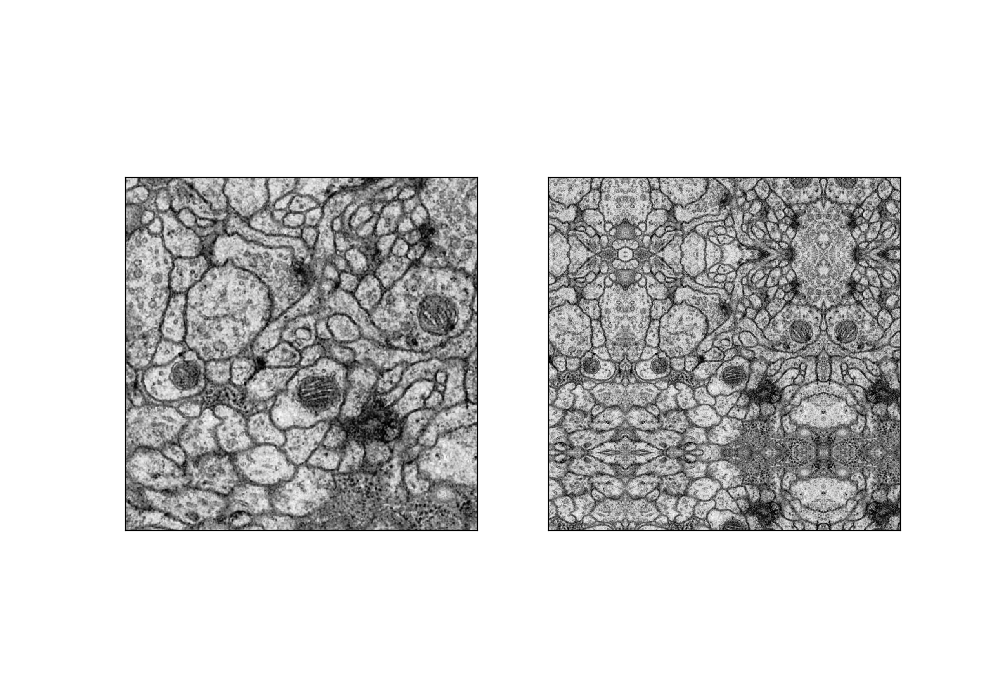

In [118]:
fig, axes = plt.subplots(figsize=(10,7), nrows=1, ncols=2)
padded = np.pad(X, 199, mode='reflect')
imgs = [X, padded]
for ax, img in zip(axes.flatten(), imgs):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img, cmap='Greys_r')

In [10]:
imgs = []
for i in range(12):
    for j in range(12):
        imgs.append(X[i*37:68+i*37,j*37:68+j*37])

<IPython.core.display.Javascript object>


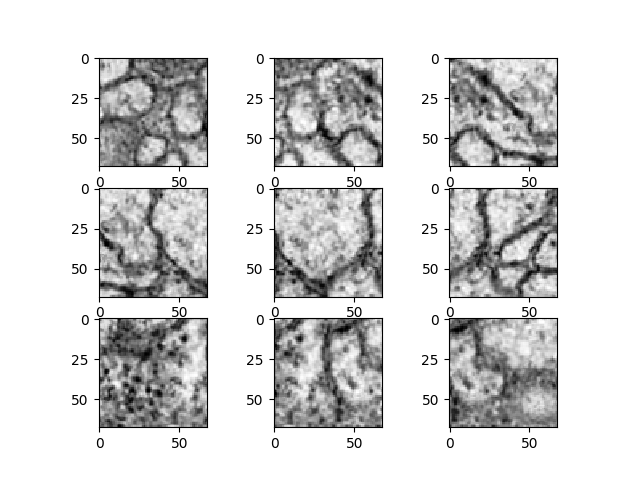

In [11]:
plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(imgs[0], cmap='Greys_r')
plt.subplot(3, 3, 2)
plt.imshow(imgs[1], cmap='Greys_r')
plt.subplot(3, 3, 3)
plt.imshow(imgs[2], cmap='Greys_r')
plt.subplot(3, 3, 4)
plt.imshow(imgs[3], cmap='Greys_r')
plt.subplot(3, 3, 5)
plt.imshow(imgs[4], cmap='Greys_r')
plt.subplot(3, 3, 6)
plt.imshow(imgs[5], cmap='Greys_r')
plt.subplot(3, 3, 7)
plt.imshow(imgs[-3], cmap='Greys_r')
plt.subplot(3, 3, 8)
plt.imshow(imgs[-2], cmap='Greys_r')
plt.subplot(3, 3, 9)
plt.imshow(imgs[-1], cmap='Greys_r')
plt.show()

In [167]:
d = DBSCAN(eps=np.sqrt(2),  min_samples=5, metric='euclidean')
X = np.transpose(np.nonzero(labels[4]))
y = d.fit_predict(X)
img = labels[4].copy()
img[np.nonzero(labels[4])] = y + 1

<IPython.core.display.Javascript object>


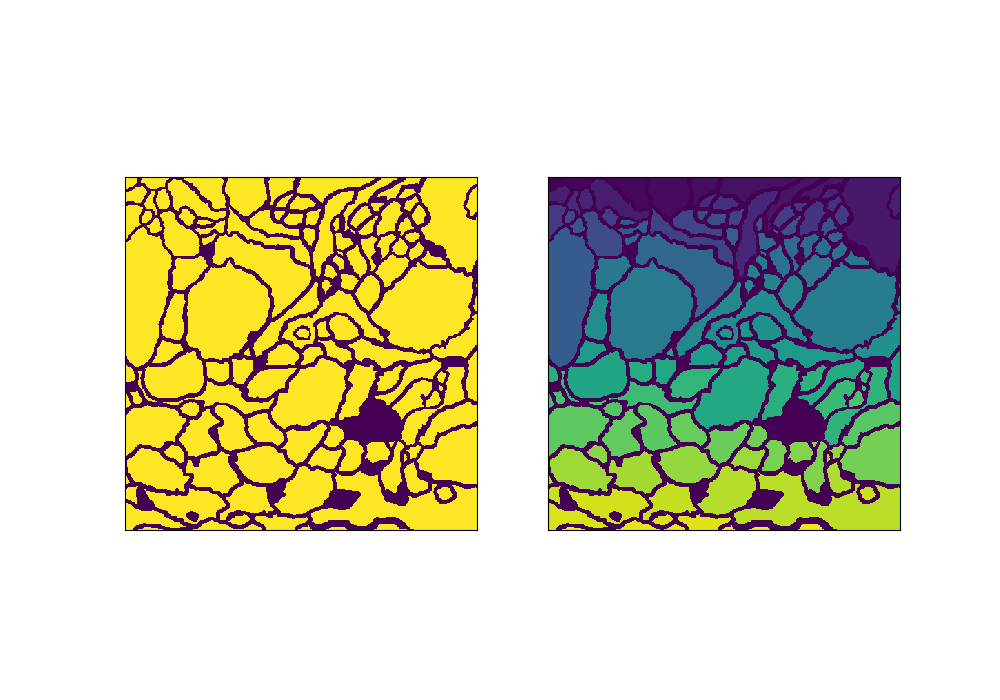

In [168]:
fig, axes = plt.subplots(figsize=(10,7), nrows=1, ncols=2)
axes.flatten()[0].xaxis.set_visible(False)
axes.flatten()[0].yaxis.set_visible(False)
im = axes.flatten()[0].imshow(labels[4])
axes.flatten()[1].xaxis.set_visible(False)
axes.flatten()[1].yaxis.set_visible(False)
im = axes.flatten()[1].imshow(img)

In [210]:
rows, cols = np.where(img == 0)

In [222]:
d1 = np.zeros(img.shape)
d2 = np.zeros(img.shape)
for i, j in tqdm(zip(rows, cols)):
    dist = 1
    dist1 = None
    dist2 = None
    label = img[i, j]
    while True:
        square = set(img[
            max(i-dist, 0): min(i+dist+1, img.shape[0]),
            max(j-dist, 0): min(j+dist+1, img.shape[1])
        ].flatten())
        square.remove(label)
        try:
            square.remove(0)
        except:
            pass
        if square:
            if len(square) > 1:
                dist1 = dist2 = dist
                break
            if dist1 is None:
                dist1 = dist
                dist += 1
                continue
            dist2 = dist
            break
        dist += 1
    d1[i, j] = dist1
    d2[i, j] = dist2

192933it [03:07, 1030.27it/s]


In [212]:
rows, cols = np.where(img != 0)

for i, j in zip(rows, cols):
    dist = 1
    label = img[i, j]
    while True:
        square = set(img[
            max(i-dist, 0): min(i+dist+1, img.shape[0]),
            max(j-dist, 0): min(j+dist+1, img.shape[1])
        ].flatten())
        square.remove(label)
        try:
            square.remove(0)
        except KeyError:
            pass
        if square:
            break
        dist += 1
    d2[i, j] = dist

In [217]:
weights = ((1 - np.mean(labels[4])) * labels[4] + 10 * np.exp(-((d1 + d2)**2)/ (2 * 5**2)))

<IPython.core.display.Javascript object>


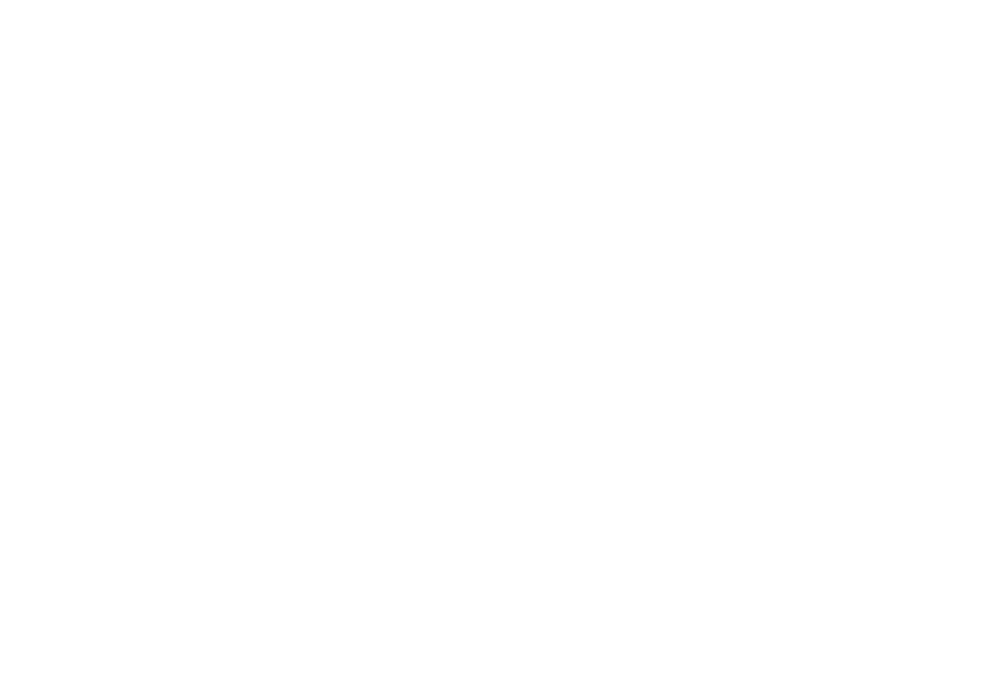

NameError: name 'd1' is not defined

In [4]:
fig, axes = plt.subplots(figsize=(10,7), nrows=2, ncols=2)
axes.flatten()[0].xaxis.set_visible(False)
axes.flatten()[0].yaxis.set_visible(False)
im = axes.flatten()[0].imshow(d1, cmap='plasma')
axes.flatten()[1].xaxis.set_visible(False)
axes.flatten()[1].yaxis.set_visible(False)
im = axes.flatten()[1].imshow(d2, cmap='plasma')
axes.flatten()[2].xaxis.set_visible(False)
axes.flatten()[2].yaxis.set_visible(False)
im = axes.flatten()[2].imshow(labels[4])
axes.flatten()[3].xaxis.set_visible(False)
axes.flatten()[3].yaxis.set_visible(False)
im = axes.flatten()[3].imshow(images[0], cmap='plasma')

In [233]:
tmp = np.vstack((weights.reshape(1, 512, 512), weights.reshape(1, 512, 512)))

In [249]:
imwrite('data/temp.tif', tmp)